## Summary

To have the flow differing from poiseuille flow within $1e-10$, we need to be $7R$ away from the obstruction in the tube. 

In [1]:
import numpy as np
import sys
sys.path.append('../src/')
import geometry
from matplotlib import pyplot as plt
from scipy.special import p_roots
from scipy.sparse.linalg import gmres

In [2]:
tube = geometry.obstructed_tube(N=4096)
a, da, t, dt_da, k = tube.get_data()

x = t.real
y = t.imag
u = 1 - y**2
v = np.zeros(len(a))
u[np.abs(t.real) <= 1] = 0

h2 = u
h1 = -v

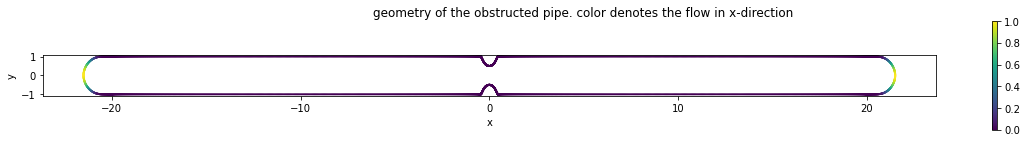

In [3]:
fig, ax = plt.subplots(figsize=(20,2))
ax.scatter(t.real, t.imag, c=u,s=1)
ax.set_xlabel('x')
ax.set_ylabel('y')
im = ax.set_aspect(1)
fig.suptitle('geometry of the obstructed pipe. color denotes the flow in x-direction')
fig.colorbar(im)

## solving the flow

In [4]:
def kernels(t,dt_da,h,curvature):
    dt = t[:,np.newaxis] - t[np.newaxis,:]
    d = dt_da[np.newaxis,:]
    hh = h[np.newaxis,:]
    
    # this ignore the error for computing the diagonal elements with 0/0 error
    with np.errstate(divide='ignore',invalid='ignore'):
        K1 = -hh * np.imag(d/dt) / np.pi
        K2 = -hh * (-d/np.conjugate(dt) + np.conjugate(d)*dt/(np.conjugate(dt**2))) / (2j*np.pi)
    # now we need to fill the diagonal elements
    d = dt_da
    K1_diagonal = curvature*np.abs(d)*h/(2*np.pi)
    K2_diagonal = -h*curvature*(d**2)/(np.abs(d)*2*np.pi)
    np.fill_diagonal(K1,K1_diagonal)
    np.fill_diagonal(K2,K2_diagonal)
    
    return K1,K2

In [5]:
K1, K2 = kernels(t, dt_da, da, k)

In [6]:
n = len(t)

In [7]:
A = np.zeros((2*n,2*n))
A[:n,:n] = np.identity(n) + (K1+K2).real
A[:n,n:] = (-K1+K2).imag
A[n:,:n] = (K1+K2).imag
A[n:,n:] = np.identity(n) + (K1-K2).real
rhs = np.concatenate((h1,h2))

In [8]:
omega, _ = gmres(A, rhs, tol=1e-12)
if _ == 0:
    print('gmres converged')
else:
    print('gmres did not converge')

omega = omega[:n] + 1j*omega[n:]

gmres converged


In [9]:
def evaluation(z,omega,t,da,dt_da):
    
    d_t = dt_da*da
    t_minus_z = t-z
    t_minus_z_square = t_minus_z**2
    
    phi = np.sum(omega*d_t/t_minus_z)/(2j*np.pi)
    d_phi = np.sum(omega*d_t/(t_minus_z**2))/(2j*np.pi)
    
    psi = (1/(2j*np.pi))*(
        2*np.sum(np.real(np.conjugate(omega)*d_t)/t_minus_z)
        - np.sum(np.conjugate(t)*omega*d_t/t_minus_z_square))
    
    dW = phi + z*np.conjugate(d_phi) + np.conjugate(psi)
    
    return dW


# return to poiseuille

In [102]:
grid = np.array([(x,y) for x in np.linspace(0,20,100) for y in np.linspace(0,0.9,10)])
grid_x, grid_y = grid.T
grid_z = grid_x + 1j*grid_y
grid_z = grid_z.reshape((100,10)).T
grid_val = np.array([evaluation(z,omega,t,da,dt_da) for z in grid_z.flatten()]).reshape(grid_z.shape)
poi_val = (1 - grid_z.flatten().imag ** 2).reshape(grid_z.shape)*1j

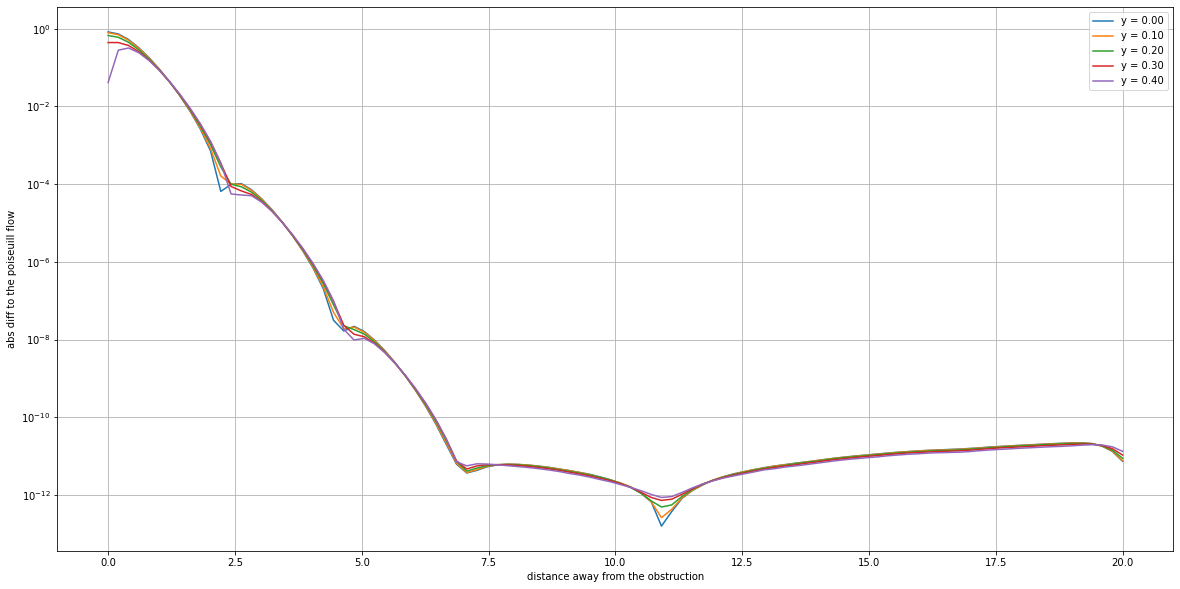

In [103]:
plt.figure(figsize=(20,10))
for i in range(5):
    z = grid_z[i]
    val = grid_val[i]
    poi = poi_val[i]
    abs_diff = np.abs(val - poi)
    y = z[0].imag
    x = z.real
    plt.semilogy(x,abs_diff,label='y = %.2f'%y)
plt.xlabel('distance away from the obstruction')
plt.ylabel('abs diff to the poiseuill flow')
plt.legend()
plt.grid('both')